# Read deviation data

There are two kinds of data in the `dev` files:

- **Deviation survey**, as measured in the well. This gives MD, Inclination, and Azimuth (measured from both true north (the north pole) and grid north (the direction of the northings in this projection).
- **Position log**, as computed from the deviation survey by whatever algorithm was preferred (it is not reported in the file.

Let's try to do several things:

- Get *position* data into a `pandas.DataFrame`
- Get *position* data into a `numpy.ndarray`
- Read LAS with `welly` and add *position* data
- Read LAS with `welly` and add *deviation* data and all the other data from the `dev` file (KB, (x, y), etc.)

---

There is not a lot of info in the LAS header, not even anything about the vertical datum. This is... a bit sad.

In [2]:
!head -55 ../data/NAM/Well_data/Groningen_field/01_Cluster_Wells/Eemskanaal/EKL-__1.las

In [6]:
!head -20 ../data/NAM/Well_data/Groningen_field/01_Cluster_Wells/Eemskanaal/EKL-__1.las

---

## Get position data into `pandas`

In [7]:
fname = "../data/NAM/Well_data/Groningen_field/01_Cluster_Wells/Eemskanaal/EKL-__1.dev"

In [9]:
import pandas as pd

names = "MD X Y Z TVD DX DY AZIM_TN INCL DLS AZIM_GN".split()

df = pd.read_csv(fname, sep=' ', skiprows=17, names=names, skipinitialspace=True)

df.head()

,MD,X,Y,Z,TVD,DX,DY,AZIM_TN,INCL,DLS,AZIM_GN
0,0.0,241602.09086,584344.22236,5.580000,0.000000,0.000000,0.000000,296.032022,0.150000,0.000000,294.999990
1,25.0,241602.03154,584344.25002,-19.419886,24.999886,-0.059318,0.027660,283.434353,0.251411,0.132000,282.402321
2,50.0,241601.92440,584344.27358,-44.419624,49.999624,-0.166456,0.051221,244.996282,0.107777,0.215918,243.964250
3,75.0,241601.88215,584344.25294,-69.419556,74.999556,-0.208710,0.030579,254.449254,0.028625,0.095615,253.417222
4,100.0,241601.87018,584344.24938,-94.419525,99.999525,-0.220681,0.027015,305.087814,0.089898,0.090095,304.055782


---

## Get position data into `numpy`

In [10]:
import numpy as np

position = np.genfromtxt(fname, skip_header=17)
position.shape

(117, 11)

---

## Add position log to `welly.Well` object directly

In [11]:
from welly import Well

w = Well.from_las('../data/NAM/Well_data/Groningen_field/01_Cluster_Wells/Eemskanaal/EKL-__1.las')

/home/matt/anaconda3/envs/geocomp/lib/python3.8/site-packages/welly/well.py:173: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)


In [12]:
w.location

Location({'td': None, 'crs': CRS({}), 'location': '', 'province': '', 'api': '', 'deviation': None, 'position': None})

In [13]:
w.location.position = position[:, [1, 2, 3]]

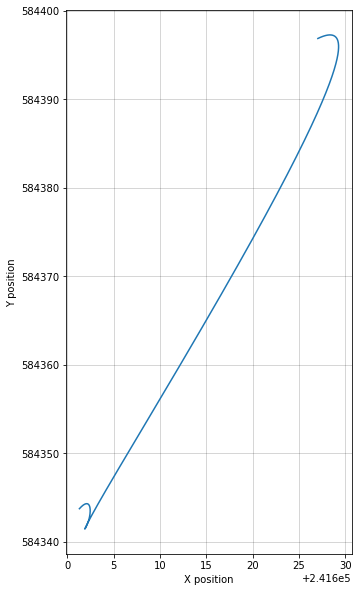

In [14]:
w.location.plot_plan()

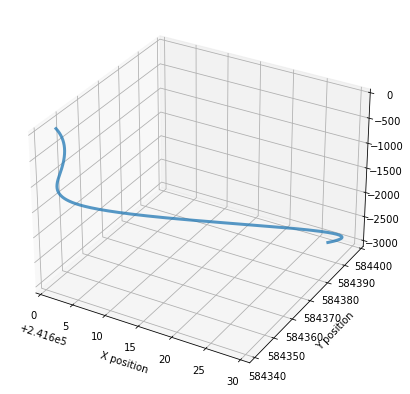

In [15]:
w.location.plot_3d()

Note that adding the position log does not give you a deviation survey, because the latter is typically "canonical" data and perhaps should not come from the position log (which is usually computed from the deviation).

In [16]:
w.location.deviation

---

## Computing position from the deviation survey with `welly`

We need the KB of the well.

    # WELL TRACE FROM PETREL 
    # WELL NAME:              EKL-  1
    # DEFINITIVE SURVEY:      Explicit survey 1
    # WELL HEAD X-COORDINATE: 241602.09085816 (m)
    # WELL HEAD Y-COORDINATE: 584344.22236241 (m)
    # WELL DATUM (KB, Kelly bushing, from MSL): 5.57999992 (m)
    # WELL TYPE:              UNDEFINED
    # MD AND TVD ARE REFERENCED (=0) AT WELL DATUM AND INCREASE DOWNWARDS
    # ANGLES ARE GIVEN IN DEGREES
    # XYZ TRACE IS GIVEN IN COORDINATE SYSTEM Amersfoort / RD New [1672_28992] (NL Onshore) [Petrel,700049]
    # AZIM_TN: azimuth in True North 
    # AZIM_GN: azimuth in Grid North 

In [17]:
x = Well.from_las('../data/NAM/Well_data/Groningen_field/01_Cluster_Wells/Eemskanaal/EKL-__1.las')
x.location

/home/matt/anaconda3/envs/geocomp/lib/python3.8/site-packages/welly/well.py:173: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)


Location({'td': None, 'crs': CRS({}), 'location': '', 'province': '', 'api': '', 'deviation': None, 'position': None})

In [19]:
import re
from welly import CRS

fields = {
    'x': (r"X-COORDINATE: ([.0-9]+).+?", float),
    'y': (r"Y-COORDINATE: ([.0-9]+).+?", float),
    'kb': (r"# WELL DATUM .+?: ([.0-9]+).+?", float),
    'crs': (r"XYZ TRACE .+? \[\d+_(\d+)\] .+?", CRS.from_epsg),
}


with open(fname) as f:
    params = {}
    crs = None
    for line in f:
        for field, (pattern, func) in fields.items():
            if pattern[:10] in line:
                try:
                    value = re.search(pattern, line).groups()[0]
                except:
                    value = np.nan
                params[field] = func(value)
            
params

{'x': 241602.09085816,
 'y': 584344.22236241,
 'kb': 5.57999992,
 'crs': CRS({'init': 'epsg:28992', 'no_defs': True})}

In [20]:
from welly import Location

x.location = Location(params=params)
x.location

Location({'td': None, 'crs': CRS({'init': 'epsg:28992', 'no_defs': True}), 'x': 241602.09085816, 'y': 584344.22236241, 'kb': 5.57999992, 'deviation': None, 'position': None})

In [21]:
x.location.add_deviation(position[:, [0, 8, 10]])

Now the well has a position log, computed from this deviation survey:

In [22]:
x.location.position

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.32281109e-02,  2.56103780e-02,  2.49998445e+01],
       [-1.57924564e-01,  2.70699103e-02,  4.99997226e+01],
       [-1.85036968e-01,  1.49668686e-02,  7.49997030e+01],
       [-2.07271149e-01,  2.41675973e-02,  9.99996896e+01],
       [-2.30634796e-01,  4.83641971e-02,  1.24999666e+02],
       [-2.32966026e-01,  7.34948864e-02,  1.49999653e+02],
       [-2.17021041e-01,  8.30711306e-02,  1.74999644e+02],
       [-1.94254135e-01,  5.72958047e-02,  1.99999618e+02],
       [-1.76810146e-01, -1.34701378e-02,  2.24999507e+02],
       [-1.65917167e-01, -1.17201751e-01,  2.49999289e+02],
       [-1.54046089e-01, -2.35364675e-01,  2.74999007e+02],
       [-1.34416340e-01, -3.68751953e-01,  2.99998642e+02],
       [-1.13013374e-01, -5.09893168e-01,  3.24998235e+02],
       [-1.06599054e-01, -6.48091533e-01,  3.49997851e+02],
       [-1.15597676e-01, -7.84908784e-01,  3.74997475e+02],
       [-1.34066527e-01, -9.17446467e-01

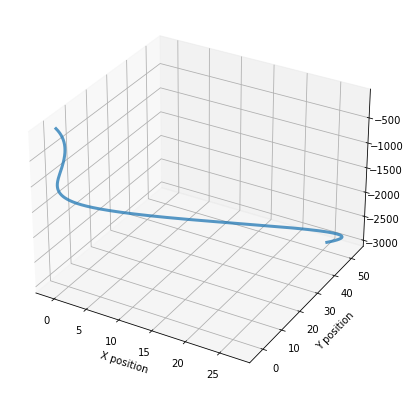

In [23]:
x.location.plot_3d()